<a href="https://colab.research.google.com/github/raj26000/Python-and-Machine-Learning/blob/main/DrivenDataFlu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
import lightgbm as lgb
!pip install verstack
from verstack import NaNImputer

from google.colab import drive
from google.colab import files
sns.set()

  Created wheel for verstack: filename=verstack-0.3.1-cp37-none-any.whl size=14342 sha256=82b521f2fc4be417e6a45436a6c8e49c99cfa33131d30d11c284d649a53e4cd4
  Stored in directory: /root/.cache/pip/wheels/15/1b/58/10e59516150cea4d9b1dbacceb3bffcc0cfd2d166efabec2f6
Successfully built verstack


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
train_labels = pd.read_csv('/content/drive/MyDrive/training_set_labels.csv')
y_train_h1n1 = train_labels['h1n1_vaccine']
y_train_seasonal = train_labels['seasonal_vaccine']
print(Counter(y_train_seasonal))
Counter(y_train_h1n1)

Counter({0: 14272, 1: 12435})


Counter({0: 21033, 1: 5674})

In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/training_set_features.csv')
train_data

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [5]:
test_data = pd.read_csv('/content/drive/MyDrive/test_set_features.csv')
test_ids = test_data['respondent_id']
test_data

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,4.0,1.0,1.0,18 - 34 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,4.0,2.0,5.0,4.0,4.0,55 - 64 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,2.0,2.0,4.0,4.0,2.0,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,2.0,4.0,4.0,4.0,2.0,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,4.0,2.0,2.0,4.0,2.0,1.0,35 - 44 Years,NaN,White,Female,NaN,NaN,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0,NaN,NaN
26704,53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,1.0,5.0,2.0,2.0,18 - 34 Years,12 Years,White,Male,Below Poverty,Married,Rent,Employed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov
26705,53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,1.0,4.0,3.0,1.0,18 - 34 Years,Some College,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26706,53413,3.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,2.0,3.0,4.0,4.0,3.0,2.0,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,bhuqouqj,"MSA, Not Principle City",1.0,0.0,NaN,NaN


# II. Data Preprocessing - Steps.



*   Checking Missing Data in Columns.

In [6]:
test_data.isnull().sum()

respondent_id                      0
h1n1_concern                      85
h1n1_knowledge                   122
behavioral_antiviral_meds         79
behavioral_avoidance             213
behavioral_face_mask              19
behavioral_wash_hands             40
behavioral_large_gatherings       72
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            932
child_under_6_months             813
health_worker                    789
health_insurance               12228
opinion_h1n1_vacc_effective      398
opinion_h1n1_risk                380
opinion_h1n1_sick_from_vacc      375
opinion_seas_vacc_effective      452
opinion_seas_risk                499
opinion_seas_sick_from_vacc      521
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4497
m

In [7]:
train_data.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m


*   Feature Encoding for Categorical Variables.
(Our data has only categorical features)



In [8]:
def preprocess_data(df):
  #Dropping columns with high percentage of missing values.
  df = df.drop(['respondent_id', 'health_insurance', 'employment_industry', 'employment_occupation'], axis=1)
  to_encode = ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
               'hhs_geo_region', 'census_msa', 'household_adults', 'household_children']
  
  #For each categorical variable, map the categories to numbers ordinally and replace in df.
  for col in to_encode:
    label_map = {}
    i=0
    if np.nan not in Counter(df[col]).keys():
      for key in Counter(df[col]).keys(): 
        label_map[key]=i
        i+=1
    else:
      for key in Counter(df[col]).keys():
        if i<=len(Counter(df[col]))-2:
          label_map[key]=i
          i+=1
    df[col].replace(label_map, inplace=True)
  
  return df

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)



*   Imputing missing values using the **verstack** Package.
Check out this [link](https://medium.com/swlh/impute-missing-values-the-right-way-c63735fccccd) for details




In [9]:
imputer = NaNImputer()
train_data = imputer.impute(train_data)
test_data = imputer.impute(test_data)


Dataset dimensions:
 - rows:         26707
 - columns:      32
 - mb in memory: 6.52
 - NaN cols num: 25
--------------------------

Deploy multiprocessing with 2 parallel proceses

- h1n1_knowledge:                imputed 116 NaNs
- behavioral_antiviral_meds:     imputed 71 NaNs
- h1n1_concern:                  imputed 92 NaNs
- behavioral_face_mask:          imputed 19 NaNs
- behavioral_avoidance:          imputed 208 NaNs
- behavioral_wash_hands:         imputed 42 NaNs
- behavioral_large_gatherings:   imputed 87 NaNs
- behavioral_touch_face:         imputed 128 NaNs
- behavioral_outside_home:       imputed 82 NaNs
- doctor_recc_seasonal:          imputed 2160 NaNs
- doctor_recc_h1n1:              imputed 2160 NaNs
- child_under_6_months:          imputed 820 NaNs
- chronic_med_condition:         imputed 971 NaNs
- health_worker:                 imputed 804 NaNs
- opinion_h1n1_vacc_effective:   imputed 391 NaNs
- opinion_h1n1_risk:             imputed 388 NaNs
- opinion_h1n1_sick_f

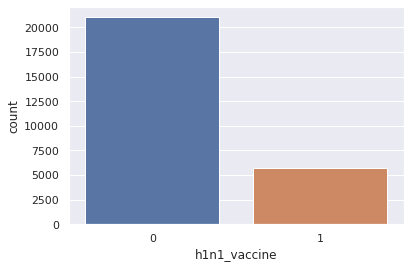

In [10]:
#Distribution of class labels for both target variables.
sns.countplot(x=y_train_h1n1)

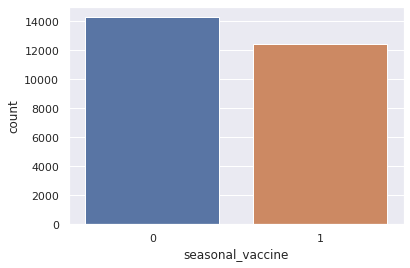

In [11]:
sns.countplot(x=y_train_seasonal)

# III. Feature Selection

In [13]:
#We use the chi2 metric for categorical variables
f, p_value = chi2(train_data, y_train_h1n1)
drop_feat_h1n1 = []
for i in range(len(p_value)):
  if p_value[i] > 0.05:
    drop_feat_h1n1.append(train_data.columns[i])

f, p_value = chi2(train_data, y_train_seasonal)
drop_feat_seasonal = []
for i in range(len(p_value)):
  if p_value[i] > 0.05:
    drop_feat_seasonal.append(train_data.columns[i])

print(drop_feat_h1n1, drop_feat_seasonal)
train_data_h1n1 = train_data.drop(drop_feat_h1n1, axis=1)
test_data_h1n1 = test_data.drop(drop_feat_h1n1, axis=1)
test_data_seasonal = test_data.drop(drop_feat_seasonal, axis=1)
train_data_seasonal = train_data.drop(drop_feat_seasonal, axis=1)

['opinion_seas_sick_from_vacc', 'census_msa'] ['behavioral_antiviral_meds', 'hhs_geo_region', 'census_msa']


# IV. Model Training



*   Grid Search Hyperparameter Tuning 



In [17]:
#Using RF Classifier(Bagging) for final results, since it gave best results among various other boosting algorithms.
#Training separate classifiers for both target variables, as diff features have been dropped.

clf1 = RandomForestClassifier()
clf2 = RandomForestClassifier()
param_grid = {'n_estimators':[800,1000,1200,1500], 'criterion':['gini', 'entropy']}
grid1 = GridSearchCV(estimator=clf1, param_grid=param_grid, cv=5, n_jobs=1, scoring=make_scorer(roc_auc_score))
grid2 = GridSearchCV(estimator=clf2, param_grid=param_grid, cv=5, n_jobs=1, scoring=make_scorer(roc_auc_score))
cv_res1 = grid1.fit(train_data, y_train_h1n1)
cv_res2 = grid2.fit(train_data, y_train_seasonal)

print(cv_res1.best_params_)
print(cv_res2.best_params_)

{'criterion': 'entropy', 'n_estimators': 800}
{'criterion': 'gini', 'n_estimators': 800}


In [18]:
#Making predictions with optimized models, probabilites to be submitted.
best_clf1 = cv_res1.best_estimator_
best_clf2 = cv_res2.best_estimator_
best_clf1.fit(train_data, y_train_h1n1)
y_prob_h1n1 = best_clf1.predict_proba(test_data)[:,1]
best_clf2.fit(train_data, y_train_seasonal)
y_prob_seasonal = best_clf2.predict_proba(test_data)[:,1]

In [19]:
#Store and download prediction file.
#Highest score attained on dataset:  0.8194 (ROC-AUC)
pred = pd.DataFrame()
pred['respondent_id'] = test_ids
pred['h1n1_vaccine'] = y_prob_h1n1
pred['seasonal_vaccine'] = y_prob_seasonal
pred.to_csv('Labels.csv', index=False)
files.download('Labels.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>